### Set your directories.

Edit ```basedir``` according to the location of folder containing this repo.



In [1]:
basedir = '/home/abhinavgupta0110/generalized_nCM'

import os

is_google_colab = False
is_use_GPU = False

Edit ```os.chdir(os.path.join(basedir, 'Poly_Collocation_Solver'))``` with the folder name containing this repo.

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

os.chdir(os.path.join(basedir, 'generalized_nCMs'))

%load_ext autoreload

### Load packages as per need.

In [3]:
%autoreload 2

from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.helper_classes import * 
import src.kdv_burgers_eqn_case.kdv_burgers_eqn as burg
from src.kdv_burgers_eqn_case.kdv_burgers_eqn_helper_classes import * 

from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm

from matplotlib.animation import FuncAnimation, PillowWriter
from numpy import random

### Define some useful classes

In [4]:
class ad_eqn_analy:

    def __init__(self, x, app):
        self.x = x
        self.app = app

    def __call__(self, t):
        
        theta_1 = self.app.eta_1 * (self.x - self.app.x_1 - (4. * self.app.eta_1**2 * t))
        theta_2 = self.app.eta_2 * (self.x - self.app.x_2 - (4. * self.app.eta_2**2 * t))
        
        u = (8. * (self.app.eta_1**2 - self.app.eta_2**2) * (self.app.eta_1**2 * np.cosh(theta_2)**2 + self.app.eta_2**2 * np.sinh(theta_1)**2)) \
            / ((self.app.eta_1 - self.app.eta_2) * np.cosh(theta_1 + theta_2) + (self.app.eta_1 + self.app.eta_2) * np.cosh(theta_1 - theta_2))**2
        
        return tf.convert_to_tensor([u], dtype=tf.float32)

### Main part starts here

#### User-defined parameters and create objects

In [5]:
args = burg.kdv_burg_args(T = 1.5, nt = 150, x_left = -10, x_right = 10, Nx = 200, dbc_l = 1, nbc_l = 0, dbc_r = 0, nbc_r = 1, max_deriv = 3, 
                          acc = 4, acc_advec = 2, eta_1 = 1.2, eta_2 = 0.8, x_1 = -6.0, x_2 = -2.0)
model_dir = 'burgers_fd/model_dir_case_test'

In [6]:
os.chdir(basedir)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
os.chdir(model_dir)

In [7]:
grid_obj = fdgen.grid(args)
u0 = initial_cond(grid_obj.x_grid, args)

t = tf.linspace(0., args.T, args.nt)

In [8]:
deriv_obj = fdgen.deriv(args, grid_obj)

sol_obj = burg.burg_rhs(args, deriv_obj, grid_obj)

#### Solve and plot

In [9]:
u = ddeinttf(sol_obj, u0, t, alg_name = 'vode', nsteps = 200)

/home/abhinavgupta0110/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:1013: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


In [10]:
import pickle

data_dict = {'u':u, 't': t}

with open('burgers_T'+str(args.T)+'_nt'+str(args.nt)+'_Nx'+str(args.Nx)+'_Re'+str(args.Re)+'_vode.pkl', 'wb') as output:
    pickle.dump(data_dict, output, pickle.HIGHEST_PROTOCOL)

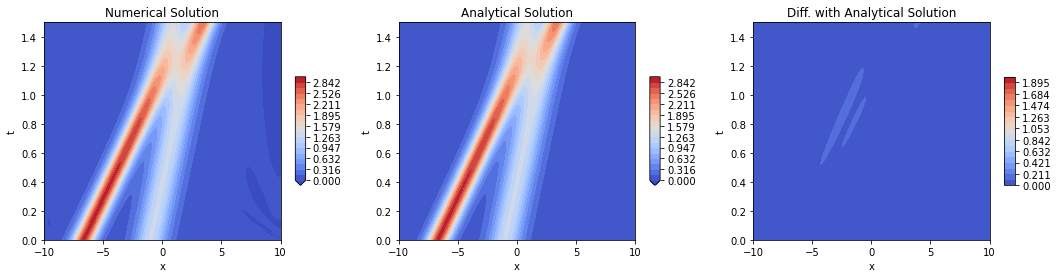

In [11]:
## # First plot the solution on the original grid
###########################################################
fig = plt.figure(figsize=(18, 4), facecolor='white')
ax_u = fig.add_subplot(131)
ax_u_analy = fig.add_subplot(132)
ax_u_diff = fig.add_subplot(133)

X, T = np.meshgrid(grid_obj.x_grid, t.numpy())

ax_u.cla()
ax_u.set_title('Numerical Solution')
ax_u.set_xlabel('x')
ax_u.set_ylabel('t')
plot = ax_u.contourf(X, T, tf.squeeze(u, axis=1).numpy(), cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(0, 3., 20), extend='min')
ax_u.set_xlim(grid_obj.x_grid[0], grid_obj.x_grid[-1])
ax_u.set_ylim(t[0], t[-1])
plt.colorbar(plot, ax=ax_u, shrink=0.5, aspect=10)

###########################################################
# Plot analytical solution
###########################################################
ad_eqn_ana_inst = ad_eqn_analy(grid_obj.x_grid, args)

u_analy = []

for i in range(args.nt):
    u_analy.append(tf.expand_dims(ad_eqn_ana_inst(t[i]), axis = 1))
    
u_analy = tf.concat(u_analy, axis=0)

ax_u_analy.cla()
ax_u_analy.set_title('Analytical Solution')
ax_u_analy.set_xlabel('x')
ax_u_analy.set_ylabel('t')
plot = ax_u_analy.contourf(X, T, tf.squeeze(u_analy, axis=1).numpy(), cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(0, 3., 20), extend='min')
ax_u_analy.set_xlim(grid_obj.x_grid[0], grid_obj.x_grid[-1])
ax_u_analy.set_ylim(t[0], t[-1])
plt.colorbar(plot, ax=ax_u_analy, shrink=0.5, aspect=10)

###########################################################
# Plot difference w.r.t. analytical solution
###########################################################

ax_u_diff.cla()
ax_u_diff.set_title('Diff. with Analytical Solution')
ax_u_diff.set_xlabel('x')
ax_u_diff.set_ylabel('t')
plot = ax_u_diff.contourf(X, T, tf.squeeze(tf.abs(u - u_analy), axis=1).numpy(), cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(0, 2., 20))
ax_u_diff.set_xlim(grid_obj.x_grid[0], grid_obj.x_grid[-1])
ax_u_diff.set_ylim(t[0], t[-1])
plt.colorbar(plot, ax=ax_u_diff, shrink=0.5, aspect=10)

fig.show()

In [12]:
class compute_error():
    
    def __init__(self, truth, thres = 0.02):
        self.truth = truth
        self.thres = thres
        
    def l2_error(self, pred):
        
        error = tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.math.squared_difference(pred, self.truth), axis=-1)), axis=0)
        
        return np.squeeze(error.numpy())
    
    def RMSE(self, pred):
        
        thres = tf.reduce_max(self.truth)*self.thres
        error = []
        diff = pred - self.truth
        
        for i in range(1, pred.shape[0]):
            diff_t = np.abs(np.squeeze(diff[i, :, :].numpy()))
            error_t = diff_t[np.where(diff_t >= thres)]
            if len(error_t) == 0: continue
            error_t = np.sqrt(np.sum(error_t**2)/len(error_t))
            error.append(error_t)

        error = np.mean(np.array(error))
        return error

In [13]:
err_obj = compute_error(u_analy)

In [14]:
err_obj.l2_error(u)

array(0.02509284, dtype=float32)

In [15]:
err_obj.RMSE(u)

0.08593605982015257

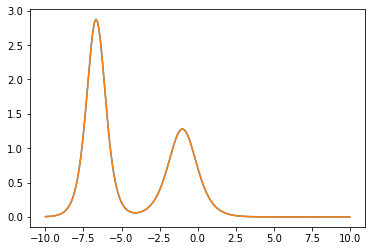

In [16]:
plt.plot(grid_obj.x_grid, u[0, 0, :])
plt.plot(grid_obj.x_grid, u_analy[0, 0, :])

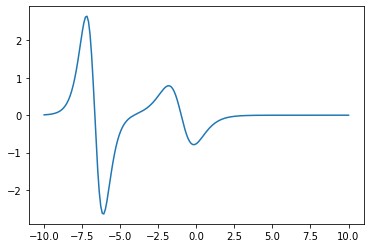

In [17]:
plt.plot(grid_obj.x_grid, np.einsum('ab, cb -> ca', sol_obj.full_vander_dx, u[:, 0, :].numpy())[0, ])

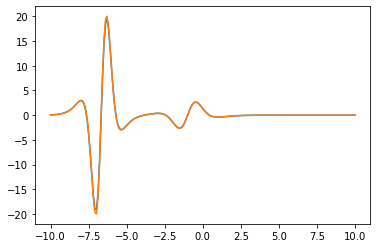

In [18]:
plt.plot(grid_obj.x_grid, np.einsum('ab, cb -> ca', sol_obj.deriv_obj.vander(grid_obj.x_grid, m=3, acc=2), u[:, 0, :].numpy())[0, ], 
        grid_obj.x_grid, np.einsum('ab, cb -> ca', sol_obj.deriv_obj.vander(grid_obj.x_grid, m=3, acc=4), u[:, 0, :].numpy())[0, ])

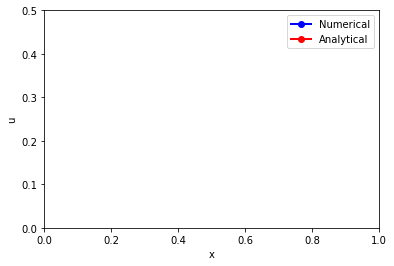

In [19]:
fig, ax = plt.subplots()
line, = plt.plot([], [], 'o-', lw=2)
labels = ['Numerical', 'Analytical']

plotlays, plotcols = [3], ["blue","red"]
lines = []
for index in range(2):
    lobj = ax.plot([],[], 'o-', lw=2,color=plotcols[index])[0]
    lines.append(lobj)

def init():
    ax.set_xlim(0, 1.)
    ax.set_ylim(0, 0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    
    for line in lines:
        line.set_data([],[])
    return lines

def update(frame):
    xdata = [grid_obj.x_grid, grid_obj.x_grid]
    ydata = [tf.squeeze(u, axis=1).numpy()[frame, :], tf.squeeze(u_analy, axis=1).numpy()[frame, :]]
    
    for lnum,line in enumerate(lines):
        line.set_data(xdata[lnum], ydata[lnum]) # set data for each line separately.
        line.set_label(labels[lnum])
        ax.legend(loc="upper right")

        fig.gca().autoscale_view()
        fig.gca().relim()
    return lines 

ani = FuncAnimation(fig, update, frames=np.arange(len(t.numpy())),
                    init_func=init, blit=True, interval=60)

ani.save('filename_res_Re'+str(args.Re)+'_Nx'+str(args.Nx)+'.gif', writer=PillowWriter(fps=24))